In [202]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
from aux import *
# from model import *
import numpy as np
import pandas as pd
import itertools
import networkx as nx

In [203]:
DATA_PATH = '../Data/'
class_ids = sorted([int(file_name.split('_')[0]) for file_name in os.listdir(DATA_PATH) if file_name.endswith('sex.csv')])

# Networks and Affective matrices of all classes in wave 1
Networks = {}
Affective = {}
for class_id in class_ids:
    Networks[class_id] = LoadData2Network(class_id, 1)
    Affective[class_id] = pd.read_csv(DATA_PATH + str(class_id) + '_affective_w1.csv', header = 0, index_col = 0)
    

In [204]:
PAYOFF_FUNCTION = {('tell a secret', 'tell a secret'): (1, 1),
                   ('tell a secret', 'refrain'): (-1, 0),
                   ('refrain', 'tell a secret'): (0, -1),
                   ('refrain', 'refrain'): (0, 0)}


In [205]:
class StudentAgent():
    def __init__(self, model, idx, gender, trust_agents, affective):
        """
        Create a new agent

        Args:
            id: unique identifier for the agent
            gender: female or male
            prob_trust: tendency to trust others (irrespective of gender)
            trust_agents: a set of agent ids which the agent trust
            affective: a dictionary of affective score rated by each agent keyed by id
            strategy: either 'tell a secret' or 'refrain'
        """

        self.model = model
        self.id = idx
        self.gender = gender
        self.trust_agents = trust_agents
        self.prob_trust = len(trust_agents) / len(affective)
        self.affective = affective
        self.strategy = None

    def play(self, opponent):
        if self.gender == 'female':
            bonus_for_gender = self.model.bonus_f2f if self.gender == opponent.gender else 0
        else:
            bonus_for_gender = self.model.bonus_m2m if self.gender == opponent.gender else 0

        bonus_for_friends = self.model.bonus_for_friends if self.affective[str(opponent.id)] == 2 else 0

        prob_cooperate = self.prob_trust + bonus_for_gender + bonus_for_friends \
                         if opponent not in self.trust_agents else 1
        if prob_cooperate > 1:
            prob_cooperate = 1

        return np.random.choice(a = ['tell a secret', 'refrain'], p = [prob_cooperate, 1 - prob_cooperate])

    def state_update(self):
        self.prob_trust = len(self.trust_agents) / len(self.affective)


In [206]:

class TrustModel():
    def __init__(self, trust_network, affective_matrix, \
                 bonus_m2m, bonus_f2f, bonus_for_friends):
        """
        Args:
            trust_network: A networkx DiGraph. Edge (A, B) exists iff A trusts B
            affective_matrix: A pandas dataframe that has the affective scores from all agents to all agents
            bonus_m2m: normalized assortativity coefficient (male, male) interpreted as probability
            bonus_f2f: normalized assortativity coefficient (female, female) interpreted as probability
            bonus_for_friends: Correlation coefficient between friends and trust
        """

        self.trust_network = trust_network
        self.affective_matrix = affective_matrix
        self.bonus_m2m = bonus_m2m
        self.bonus_f2f = bonus_f2f
        self.bonus_for_friends = bonus_for_friends
        self.agents = []

        for idx, attributes in self.trust_network.nodes(data = True):
            trust_agents = [n for n in trust_network.neighbors(idx)]
            # Initialize the affective scores from one agent (= id) to all other agents
            affective = {}
            for column_idx in affective_matrix.loc[[idx]]:
                affective[column_idx] = affective_matrix.loc[[idx]][column_idx].values[0]
            self.agents.append(StudentAgent(self, idx, attributes['sex'], set(trust_agents), affective))

    def step(self):
        """
        At each time step all pairs of agent will interact and play prisoner's dilemma once
        """

        ## Update affective_matrix according the payoff function
        for a, b in itertools.combinations(self.agents, 2):
            strategy = (a.play(b), b.play(a))
            a_payoff, b_payoff = PAYOFF_FUNCTION[strategy]
            a.affective[str(b.id)] += a_payoff
            b.affective[str(a.id)] += b_payoff

            if a.affective[str(b.id)] > 2:
                a.affective[str(b.id)] = 2 
            if a.affective[str(b.id)] < -2:
                a.affective[str(b.id)] = -2

            if b.affective[str(a.id)] > 2:
                b.affective[str(a.id)] = 2 
            if b.affective[str(a.id)] < -2:
                b.affective[str(a.id)] = -2 

            self.affective_matrix[str(a.id)][str(b.id)] = a.affective[str(b.id)]
            self.affective_matrix[str(b.id)][str(a.id)] = b.affective[str(a.id)]  

            ## Rewiring in the trust network
            # Case 1
            if strategy == ('tell a secret', 'tell a secret'):
                if (a.affective[str(b.id)] == 2) and (b not in a.trust_agents):
                    # If to_trust = 1, we create a new edge from a to b, otherweise unchanged
                    to_trust = np.random.choice(a = [0, 1], p = [1 - self.bonus_for_friends, self.bonus_for_friends])
                    if to_trust == 1:
                        a.trust_agents.add(b.id)
                        self.trust_network.add_edge(a.id, b.id)

                if (b.affective[str(a.id)] == 2) and (a not in b.trust_agents):
                    # If to_trust = 1, we create a new edge from b to a, otherweise unchanged
                    to_trust = np.random.choice(a = [0, 1], p = [1 - self.bonus_for_friends, self.bonus_for_friends])
                    if to_trust == 1:
                        b.trust_agents.add(a.id)
                        self.trust_network.add_edge(b.id, a.id)
            # Case 3
            if strategy == ('refrain', 'tell a secret') and self.trust_network.has_edge(b.id, a.id):
                self.trust_network.remove_edge(b.id, a.id)
            # Case 4
            if strategy == ('tell a secret', 'refrain') and self.trust_network.has_edge(a.id, b.id):
                self.trust_network.remove_edge(a.id, b.id)

            ## Update prob_trust of both agents
            a.state_update()
            b.state_update()
            
        return self.trust_network

In [207]:
# Set parameters
NUM_STEP = 6
bonus_m2m = 0.3
bonus_f2f = 0.3
bonus_for_friends = 0.5

In [208]:
def run(num_step, trust_network, affective_matrix, bonus_m2m, bonus_f2f, bonus_for_friends):
    model = TrustModel(trust_network = trust_network, affective_matrix = affective_matrix, \
                       bonus_m2m = bonus_m2m, bonus_f2f = bonus_f2f, bonus_for_friends = bonus_for_friends)

    networks = []
    current_step = 0
    while (current_step < num_step):
        networks.append(model.step())
        current_step += 1

    return networks

In [209]:
network = Networks[1100]
affective_matrix = Affective[1100]

simulated_networks = run(NUM_STEP, network, affective_matrix, bonus_m2m, bonus_f2f, bonus_for_friends)

print(simulated_networks)

[<networkx.classes.digraph.DiGraph object at 0x11537ecc0>, <networkx.classes.digraph.DiGraph object at 0x11537ecc0>, <networkx.classes.digraph.DiGraph object at 0x11537ecc0>, <networkx.classes.digraph.DiGraph object at 0x11537ecc0>, <networkx.classes.digraph.DiGraph object at 0x11537ecc0>, <networkx.classes.digraph.DiGraph object at 0x11537ecc0>]


In [296]:
def visualize(network, class_id, step):
    """
    Args:
        network: NetworkX DiGraph
        class_id: the unique id of class
        step: a number between 0 and NUM_STEP
    """
    
    plt.figure(figsize=(25, 8))
    plt.tight_layout()
    plt.suptitle('Simulated on Class {}, step {}'.format(class_id, step), fontsize = 30)
    
    females = [idx for idx, sex in nx.get_node_attributes(network, 'sex').items() if sex == 'female']
    males = [idx for idx, sex in nx.get_node_attributes(network, 'sex').items() if sex == 'male']
    male_network = network.subgraph(males)
    female_network = network.subgraph(females)
    
    all_edges = set(network.edges())
    female_edges = set(female_network.edges())
    male_edges = set(male_network.edges())
    pos = nx.bipartite_layout(network, females)
    
    
    # Draw network in bipartite layout, removing edges between female agents or male agents
    edgelist = all_edges - female_edges - male_edges
    plt.subplot(131)
    plt.axis('off')
    nx.draw_networkx(G = network, nodelist = females, edgelist = edgelist, \
                     pos = pos, with_labels = False, node_color = 'r')
    nx.draw_networkx(G = network, nodelist = males, edgelist = edgelist, \
                     pos = pos, with_labels = False, node_color = 'b')
    
    # Draw network of only male agents 
    plt.subplot(132)
    plt.axis('off')
    
    nx.draw_networkx(G = male_network, pos = nx.kamada_kawai_layout(male_network), \
                    with_labels = False, node_color = 'b', alpha = 0.8)

    # Draw network of only female agents
    plt.subplot(133)
    plt.axis('off')
    nx.draw_networkx(G = female_network, pos = nx.kamada_kawai_layout(female_network), \
                     with_labels = False, node_color = 'r', alpha = 0.8)

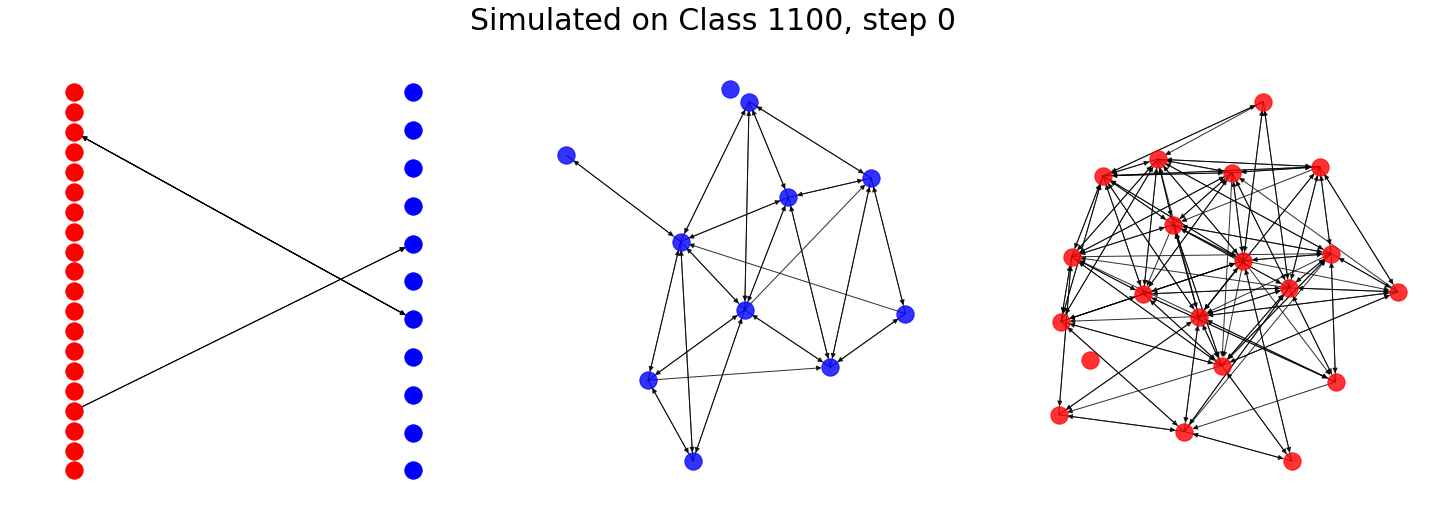

In [297]:
visualize(simulated_networks[0], 1100, 0)